In [1]:
import emcee, copy
import numpy as np
from astropy.table import Table,Column
import matplotlib.pyplot as plt
from astropy.io import ascii

        MJD                  lum           ...        t_exp       
------------------- ---------------------- ... -------------------
 0.3889999999955762   3.62869483181035e+42 ...  0.3889999999955762
0.43400000000110595 3.8309932472952433e+42 ... 0.43400000000110595
 0.4389999999984866  3.840989229838778e+42 ...  0.4389999999984866
 0.4419999999954598 3.7155887977733336e+42 ...  0.4419999999954598
0.44799999999668216  3.532749520215011e+42 ... 0.44799999999668216
0.48099999999976717  3.532627963280439e+42 ... 0.48099999999976717
 0.5279999999984284 3.5806322781177544e+42 ...  0.5279999999984284
 0.5780000000013388 3.7193836459434803e+42 ...  0.5780000000013388
 0.5800000000017462  3.633781638467529e+42 ...  0.5800000000017462
 1.3889999999955762  3.643330473615065e+42 ...  1.3889999999955762
                ...                    ... ...                 ...
 380.44199999999546  3.190721416843586e+40 ...  380.44199999999546
  381.4389999999985  3.185580056656116e+40 ...   381.438999999

  3%|▎         | 142/5000 [00:04<02:34, 31.45it/s]C:\Users\jvasq\AppData\Local\Temp\ipykernel_7384\794609706.py:9: RuntimeWarning: overflow encountered in exp
  return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)
100%|██████████| 5000/5000 [02:42<00:00, 30.74it/s]


Best-fit parameters:
Param: 0.3325855362746636 + 0.007482546784614019 - 0.007852094465381654
Param: 63.570787819778246 + 0.3759364566094163 - 0.3527252756881083
Param: 1.739033985466542 + 0.2802270255971815 - 0.25024803485477665
Param: 0.014506720033586213 + 3.206298783163357e-05 - 3.0835943649269726e-05
Param: -17.300207571435248 + 0.006587131934260526 - 0.006816661754655229
[0.3325855362746636, 63.570787819778246, 1.739033985466542, 0.014506720033586213, -17.300207571435248]
        MJD                  lum           ...        t_exp       
------------------- ---------------------- ... -------------------
 0.3889999999955762   3.62869483181035e+42 ...  0.3889999999955762
0.43400000000110595 3.8309932472952433e+42 ... 0.43400000000110595
 0.4389999999984866  3.840989229838778e+42 ...  0.4389999999984866
 0.4419999999954598 3.7155887977733336e+42 ...  0.4419999999954598
0.44799999999668216  3.532749520215011e+42 ... 0.44799999999668216
0.48099999999976717  3.532627963280439e+42 ... 0.

<Figure size 640x480 with 0 Axes>

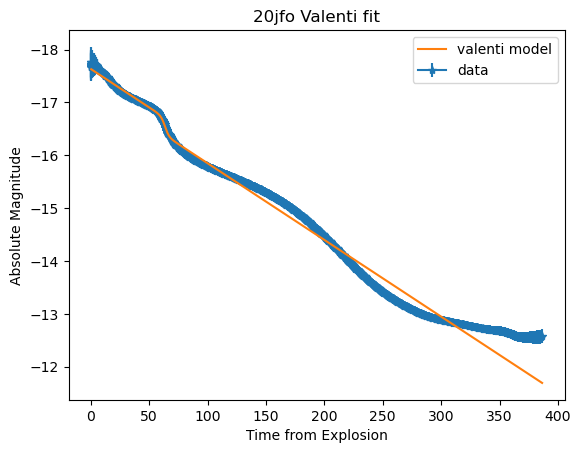

In [2]:
plt.clf()

# Input parameters - superbol file and MJD explosion/discovery date
data_file='jfo_combined_data'
mjd_start=0

def valenti_model(time, theta):
    a, tpt, w, p, m = theta
    return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)

def lnlikelihood(theta, lum, dlum, time):
    model_lum = valenti_model(time, theta)
    
    # Set parameter range value
    a, tpt, w, p, m = theta
    if a<0.01: return(-np.inf)
    if a>10.0: return(-np.inf)
    if tpt<10.0: return(-np.inf)
    if w<0.01: return(-np.inf)
    
    inv_sigma = 1./dlum**2
    return(-0.5 * np.sum((lum-model_lum)**2 * inv_sigma))

def load_table(data_file, mjd_start=mjd_start, mask_date=0):
    # The code will automatically mask data mask_date days from the input reference date.
    # Change this value in order to adjust the amount of data that's included/excluded
    
    table = Table.read(data_file, format='ascii',names=('MJD','lum','dlum'))
    #print(table)
    # Want to fit versus a magnitude rather than actual luminosity, so convert lum to Mbol
    # Here 83.9605452803 = 2.5*log10(3.839e33) for Solar luminosity
    # 4.74 is bolometric luminosity of the Sun
    table['MJD'] = table['MJD']
    Mbol = -2.5*np.log10(table['lum']) + 83.9605452803 + 4.74
    Mbolerr = 1.086 * (table['dlum'] / table['lum'])

    
    table.add_column(Column(Mbol, name='Mbol'))
    table.add_column(Column(Mbolerr, name='Mbolerr'))
    
    newcol=Column(table['MJD'].data-mjd_start,name='t_exp')
    table.add_column(newcol)
    
    mask = table['t_exp']>mask_date
    table=table[mask]
    print(table)
    return(table)

def mcmc_valenti(data_file, ndim=5, nwalkers=100, inflate_errors=0.1):
    
    # I'm adding a parameter to inflate the error bars because the code appears to underfit the
    # late time decline due to nickel, which is primarily what we're interested in
    
    params = [1.7391707763335567, 111.06179709805089, 7.203197652533321, 0.008194307783125725, -13.583601384015793]
    pos = [params + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
    
    table = load_table(data_file)
    mask = np.abs(table['MJD'] - mjd_start) < 1
    table = table[~mask]
    table['Mbolerr'] = np.sqrt(table['Mbolerr']**2+inflate_errors**2)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlikelihood, 
                                    args=(table['Mbol'],
                                          table['Mbolerr'],
                                          table['t_exp']))
    
    sampler.run_mcmc(pos, 5000, progress=True)
    samples = sampler.chain[:, 99:, :].reshape((-1, ndim))
    
    return(samples)

def get_param_uncertainties(samples):
    
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    
    vals = [v for v in vals]
    
    return(vals)
    
samples=mcmc_valenti(data_file)
params=get_param_uncertainties(samples)
   

print('Best-fit parameters:')
for p in copy.copy(params):
    print('Param: {0} + {1} - {2}'.format(p[0], p[1], p[2]))

best_fit=[p[0] for p in copy.copy(params)]
print(best_fit)
table = load_table(data_file)
plt.figure() 

plt.errorbar(table['MJD']-mjd_start, table['Mbol'], yerr=table['Mbolerr'], marker='*', zorder=5, label = 'data')

    
model_lum=valenti_model(table['MJD']-mjd_start, best_fit)

plt.plot(table['MJD']-mjd_start, model_lum, zorder=10, label = 'valenti model')

#plt.ylim([-14,-20])
plt.ylabel('Absolute Magnitude')
plt.xlabel('Time from Explosion')
plt.legend()
plt.title('20jfo Valenti fit')
plt.gca().invert_yaxis()

plt.show()

In [9]:
np.savetxt('valenti_fit_abs_mag.txt', model_lum)

In [3]:
luminosity=[]
# Using 220.0 rest-frame days as reference time
lightcurve_ref_time = 220-mjd_start
print(lightcurve_ref_time)
for s in samples:
    abs_mag=valenti_model(lightcurve_ref_time, s)
    luminosity.append(3.839e33 * 10**(-0.4 * (abs_mag-4.74)))

data = np.percentile(luminosity, [16, 50, 84])
lum=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0] 
print('Luminosity (1e39 erg/s)=','%1.2f'%(lum*1.0e-39),'+','%1.2f'%(errhi*1.0e-39),'-','%1.2f'%(errlo*1.0e-39))
print(data) 
print(errhi)
print(errlo)

# Heating rate for Co-56 decay in erg/s/g
epsilon = 6.8e9
# Mass of Co-56 in grams at 270 days
mass_Co56 = np.array(luminosity) / epsilon

# Radioactive decay timescale for Ni-56 and Co-56.  These are equal to ln(2)/(half-life)
# Half-life for Ni-56 is 6.075 days, Half-life for Co-56 is 55.93983 days
lambda_Co56 = np.log(2)/55.9383
lambda_Ni56 = np.log(2)/6.075

# Mass of Ni-56 at t=0
mass_Ni56 = mass_Co56 * (lambda_Co56 - lambda_Ni56)/lambda_Ni56 * (np.exp(-lambda_Ni56 * lightcurve_ref_time) - np.exp(-lambda_Co56 * lightcurve_ref_time))**-1
data = np.percentile(mass_Ni56, [16, 50, 84])
print(data)
mass=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0] 
print('Mass (Msun)=','%1.4f'%(mass/(1.989e33)),'+','%1.4f'%(errhi/(1.989e33)),'-','%1.4f'%(errlo/(1.989e33)))

220


C:\Users\jvasq\AppData\Local\Temp\ipykernel_7384\794609706.py:9: RuntimeWarning: overflow encountered in exp
  return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)


Luminosity (1e39 erg/s)= 132.96 + 0.31 - 0.30
[1.32660437e+41 1.32960306e+41 1.33267291e+41]
3.0698519433805672e+38
2.998693497310403e+38
[2.65599059e+32 2.66199427e+32 2.66814041e+32]
Mass (Msun)= 0.1338 + 0.0003 - 0.0003


In [4]:
lum = 10 ** ((table['Mbol']-83.96-4.74)/ -2.5 ) 

dlum = lum * (table['Mbolerr'] / 1.086)

In [19]:
model_lum_flux = 10 ** ((model_lum - 83.96 - 4.74) / -2.5)

Text(0.5, 1.0, '20jfo bol LC')

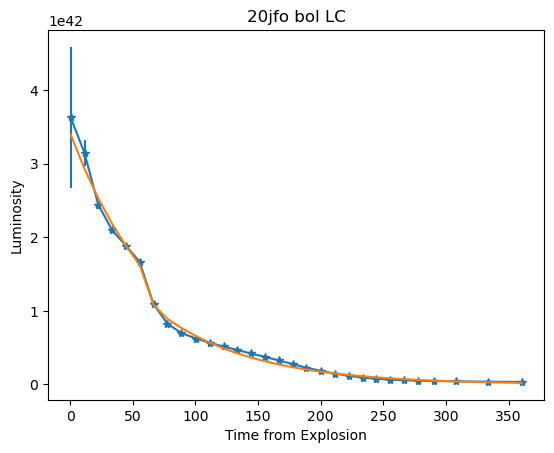

In [20]:
plt.errorbar(table['MJD'][::100], lum[::100], yerr=dlum[::100], marker='*', zorder=5, label = 'data (flux)')
plt.plot(table['MJD'][::100], model_lum_flux[::100], zorder = 10, label = 'valenti fit (flux)')
plt.xlabel('Time from Explosion')
plt.ylabel('Luminosity')
plt.title('20jfo bol LC')


Text(0.5, 1.0, '20jfo bol LC')

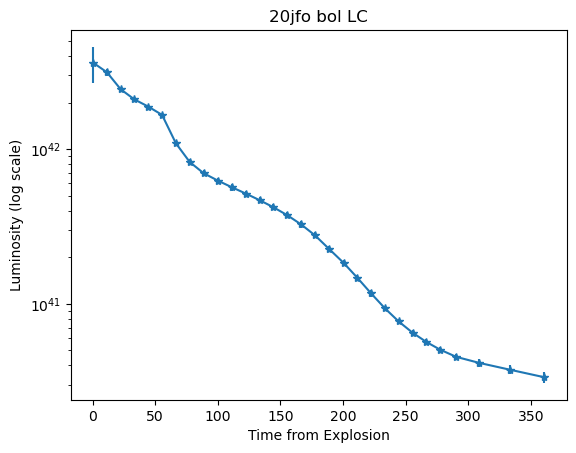

In [8]:
plt.errorbar(table['MJD'][::100], lum[::100], yerr=dlum[::100], marker='*', zorder=5, label = 'data')
plt.xlabel('Time from Explosion')
plt.ylabel('Luminosity (log scale)')
plt.yscale('log')
plt.title('20jfo bol LC')

Text(0.5, 1.0, '20jfo Valenti Fit (flux log scale)')

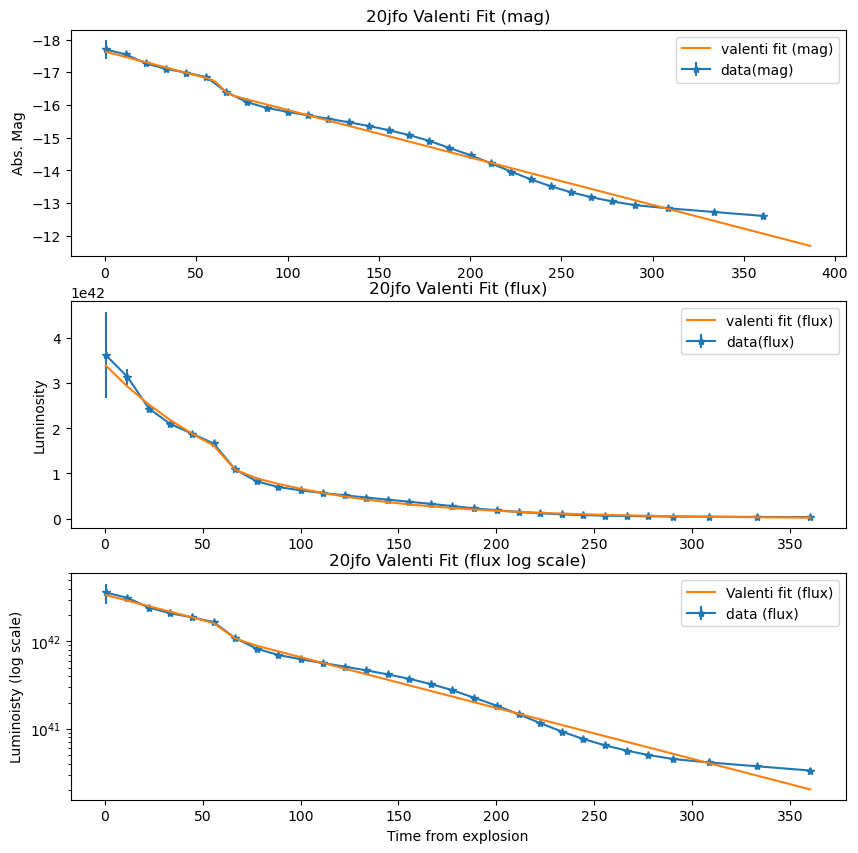

In [27]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,1,1)
fig.add_subplot(3,1,2)
fig.add_subplot(3,1,3)

plt.subplot(3,1,1)
plt.errorbar(table['MJD'][::100], table['Mbol'][::100], yerr=table['Mbolerr'][::100], marker='*', zorder=5, label = 'data(mag)') 
plt.plot(table['MJD'], model_lum, zorder = 10, label = 'valenti fit (mag)')
plt.ylabel('Abs. Mag')
plt.gca().invert_yaxis()
plt.legend()
plt.title('20jfo Valenti Fit (mag)')

plt.subplot(3,1,2)
plt.errorbar(table['MJD'][::100], lum[::100], dlum[::100], marker = '*', zorder = 5, label = 'data(flux)')
plt.plot(table['MJD'][::100], model_lum_flux[::100], zorder = 10, label = 'valenti fit (flux)')
plt.ylabel('Luminosity')
plt.legend()
plt.title('20jfo Valenti Fit (flux)') 

plt.subplot(3,1,3)
plt.errorbar(table['MJD'][::100], lum[::100], dlum[::100], marker = '*', zorder = 5, label = 'data (flux)')
plt.plot(table['MJD'][::100], model_lum_flux[::100], zorder = 10, label = 'Valenti fit (flux)')
plt.ylabel('Luminoisty (log scale)')
plt.xlabel('Time from explosion')
plt.yscale('log')
plt.legend()
plt.title('20jfo Valenti Fit (flux log scale)')